In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# --------------------- HYPERPARAMS ---------------------
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Scene/event sizes
T = 2              # time steps (x0, x1)
N = 8              # number of entities
DX = 2             # features per entity: 2D position only

# Model
DW = 16            # dimension of concept code w
HIDDEN = 128

# Training
BATCH_SIZE = 128
DEMO_SHOTS = 5     # few-shot demos per concept instance
STEPS = 800        # training iterations (increase to 5000-10000 for better quality)
LR = 1e-3
K_SGLD = 10
ALPHA_X = 1e-2     # SGLD step for x
ALPHA_A = 5e-3     # SGLD step for a
LAMBDA_KL = 1.0

# Eval/visualization
EVAL_BATCH = 1     # visualize a single instance
ATTN_THRESHOLD = 0.5


### Visualising the Tensor

[ # 128 samples
            [ # 2 timesteps
                [ # 8 entities
                    [x, y] # 2 features
                ], 
                [... 8 more entities],
            ], 
            [... another timestep],
        ], [... 127 more samples],


This block repeats

[  # 2 time steps
    [  # 8 entities
        [x, y]  # 2 features (position coordinates)
    ],
    [...7 more entities...],  # Total: 8 entities at t=0
],
[  # Second time step (t=1)
    [  # 8 entities
        [x, y]
    ],
    [...7 more entities...],  # Total: 8 entities at t=1
],

In [1]:
def mlp(sizes, act=nn.ReLU, out_act=None):
    layers = []
    for i in range(len(sizes)-1):
        layers += [nn.Linear(sizes[i], sizes[i+1])]
        if i < len(sizes)-2:
            layers += [act()]
        elif out_act is not None:
            layers += [out_act()]
    return nn.Sequential(*layers)

NameError: name 'nn' is not defined

In [4]:
out = mlp([20, 128, 128, 128], act=nn.ReLU, out_act=None)

In [5]:
out

Sequential(
  (0): Linear(in_features=20, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
)

In [1]:
import torch

# Create an input tensor
x = torch.randn(3, 3)

# Apply the sigmoid function
y = torch.sigmoid(x)

print("Input tensor:")
print(x)
print("\nOutput tensor after sigmoid:")
print(y)

Input tensor:
tensor([[-1.5304,  0.4735,  0.4727],
        [-0.0988,  0.3830, -0.9131],
        [ 1.5844,  0.9066, -0.0847]])

Output tensor after sigmoid:
tensor([[0.1779, 0.6162, 0.6160],
        [0.4753, 0.5946, 0.2864],
        [0.8298, 0.7123, 0.4788]])


In [2]:
import torch

# Create a 1D tensor
x = torch.tensor([1, 2, 3, 4])
print(f"Original tensor: {x}, shape: {x.shape}")

# Unsqueeze at dimension 0 (adds a new dimension at the beginning)
y = torch.unsqueeze(x, 0)
print(f"Unsqueeze at dim 0: {y}, shape: {y.shape}")

# Unsqueeze at dimension 1 (adds a new dimension at the end)
z = torch.unsqueeze(x, 1)
print(f"Unsqueeze at dim 1: {z}, shape: {z.shape}")

# You can also use the tensor method
a = x.unsqueeze(0)
print(f"Tensor method unsqueeze at dim 0: {a}, shape: {a.shape}")

Original tensor: tensor([1, 2, 3, 4]), shape: torch.Size([4])
Unsqueeze at dim 0: tensor([[1, 2, 3, 4]]), shape: torch.Size([1, 4])
Unsqueeze at dim 1: tensor([[1],
        [2],
        [3],
        [4]]), shape: torch.Size([4, 1])
Tensor method unsqueeze at dim 0: tensor([[1, 2, 3, 4]]), shape: torch.Size([1, 4])


In [6]:
a = torch.randn(128, 2)

sig_a = torch.sigmoid(a)   
# print(f"Sigmoid of a: {sig_a}, shape: {sig_a.shape}")

m = sig_a.unsqueeze(2)
x = sig_a.unsqueeze(1)
# print(f"Resulting tensor m: {m}, shape: {m.shape}") # [128, 2, 1] * 
print(f"Resulting tensor x: {x}, shape: {x.shape}") # [128, 1, 2] * 

Resulting tensor x: tensor([[[0.7720, 0.2243]],

        [[0.4063, 0.4389]],

        [[0.7209, 0.5196]],

        [[0.7424, 0.5547]],

        [[0.5085, 0.5871]],

        [[0.3506, 0.4246]],

        [[0.5308, 0.0913]],

        [[0.2680, 0.5506]],

        [[0.7791, 0.5077]],

        [[0.8387, 0.6937]],

        [[0.3943, 0.1614]],

        [[0.7700, 0.1808]],

        [[0.5518, 0.5606]],

        [[0.3751, 0.0958]],

        [[0.5575, 0.3723]],

        [[0.6385, 0.7656]],

        [[0.6309, 0.3882]],

        [[0.7215, 0.3302]],

        [[0.3591, 0.5637]],

        [[0.1300, 0.6671]],

        [[0.5923, 0.1602]],

        [[0.3800, 0.4719]],

        [[0.5959, 0.3156]],

        [[0.1903, 0.6827]],

        [[0.5536, 0.0871]],

        [[0.7906, 0.8919]],

        [[0.4273, 0.6411]],

        [[0.6926, 0.2921]],

        [[0.3526, 0.5982]],

        [[0.4976, 0.6215]],

        [[0.6257, 0.6877]],

        [[0.7448, 0.5250]],

        [[0.7688, 0.6636]],

        [[0.5189, 0.347

In [43]:
z = torch.randn([8, 2])
z

tensor([[-0.9727,  0.9585],
        [ 1.6192,  1.4506],
        [ 0.2695, -0.2104],
        [-0.7328,  0.1043],
        [ 0.3488,  0.9676],
        [-0.4657,  1.6048],
        [-2.4801, -0.4175],
        [-1.1955,  0.8123]])

In [ ]:
v  = z.view(-1,8) # -1 means infer the dimension size automatically
v

tensor([[ 1.9312,  1.0119, -1.4364, -1.1299, -0.1360,  1.6354,  0.6547,  0.5760],
        [ 1.1415,  0.0186, -1.8058,  0.9254, -0.3753,  1.0331, -0.6867,  0.6368]])

In [60]:
z = torch.randn([8, 1])
v = z.expand(8,4) # specify the dimension sizes explicitly
v = v.view(16,2)
v

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [ ]:
x = torch.tensor([[1], [2], [3]])
x.view(3,2)
x.shape
# x.expand(3, 4)

RuntimeError: shape '[3, 2]' is invalid for input of size 3

In [86]:
x = torch.randn([128, 2, 8, 2]) 
x = x.unsqueeze(2).expand(128, 2, 8, 8, 2)
x.shape

torch.Size([128, 2, 8, 8, 2])

In [3]:
w = torch.randn([128, 2])
a = w.view(128, 1, 1, 1, -1).expand(128, 2, 8, 8, -1)
a.shape


torch.Size([128, 2, 8, 8, 2])

In [ ]:
z = torch.cat([x, w], dim=-1) # concatenate along the last dimension
z.shape

torch.Size([128, 2, 8, 8, 4])

In [21]:
from line import LineConceptDataset
ds = LineConceptDataset(B=1, T=T, N=N, DX=2, num_samples=50_000, device=DEVICE)

Attention values: tensor([0., 3., 0., 0., 3., 3., 3., 0.])

Line entities (high attention): [1 4 5 6]
Noise entities (low attention): [0 2 3 7]


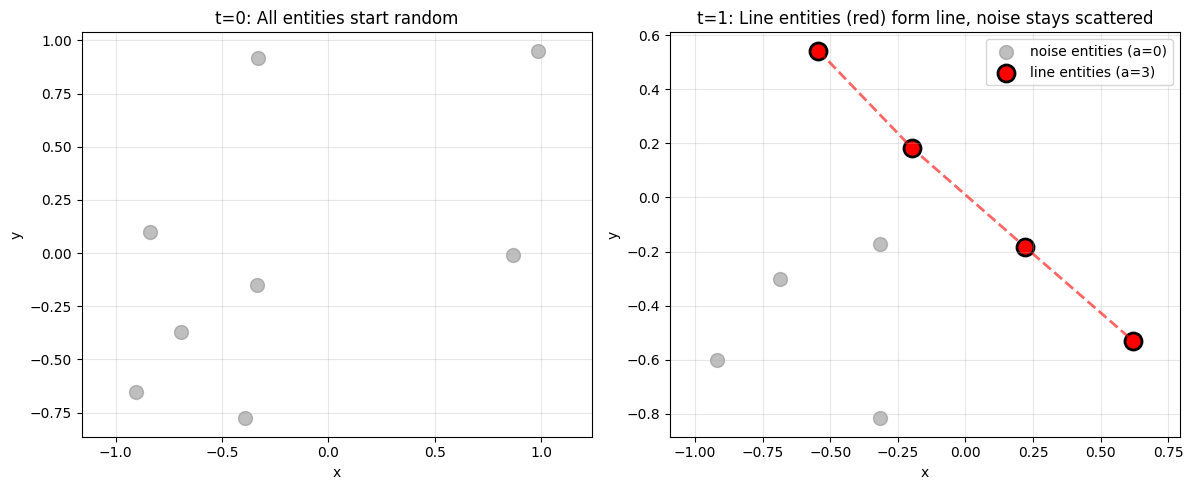

In [ ]:
# Take one sample
sample = ds[0]
x0 = sample['x0'][0].cpu()  # t=0 positions
x1 = sample['x1'][1].cpu()  # t=1 positions
a = sample['a'].cpu()       # attention labels

# Find which entities have high attention (line entities)
line_entities = torch.where(a > 1.0)[0].numpy()
noise_entities = torch.where(a < 1.0)[0].numpy()

print(f"Attention values: {a}")
print(f"\nLine entities (high attention): {line_entities}")
print(f"Noise entities (low attention): {noise_entities}")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# t=0: all random
ax1.scatter(x0[:, 0].numpy(), x0[:, 1].numpy(), c='gray', s=100, alpha=0.5)
ax1.set_title("t=0: All entities start random")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.axis("equal")
ax1.grid(True, alpha=0.3)

# t=1: line entities form line, noise entities stay scattered
x1_np = x1.numpy()
ax2.scatter(x1_np[noise_entities, 0], x1_np[noise_entities, 1], 
           c='gray', s=100, alpha=0.5, label='noise entities (a=0)')
ax2.scatter(x1_np[line_entities, 0], x1_np[line_entities, 1], 
           c='red', s=150, marker='o', label='line entities (a=3)', 
           edgecolors='black', linewidths=2)

# Draw line through line entities
if len(line_entities) >= 2:
    line_pts = x1_np[line_entities]
    sorted_idx = np.argsort(line_pts[:, 0])
    sorted_pts = line_pts[sorted_idx]
    ax2.plot(sorted_pts[:, 0], sorted_pts[:, 1], 'r--', linewidth=2, alpha=0.6)

ax2.set_title("t=1: Line entities (red) form line, noise stays scattered")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend()
ax2.axis("equal")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()